#### 2019 DEATH DATA PREP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import nltk
import spacy
import textblob

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [3]:
d19 = pd.read_csv('Y:/DQSS/Death/MBG/py/QA/data/d19_05-27-2020.csv',
                  low_memory=False,
                  encoding = 'unicode_escape')

In [4]:
d19.dtypes

sfn                  int64
sex                 object
agetype            float64
age                float64
ageyrs             float64
dob                 object
dod                 object
bcertno             object
bmatchcode         float64
dcity               object
dcityFIPS          float64
dcounty             object
dcountycityWA      float64
dcountyWA          float64
dcountyFIPS          int64
dcountyNCHS        float64
dstate              object
dstateNCHS         float64
dcountry            object
dzip                object
dplacetype         float64
dfaccode           float64
dplacelit           object
military            object
marital             object
education          float64
educ8less          float64
white               object
black               object
AIAN                object
asianind            object
chinese             object
filipino            object
japanese            object
korean              object
vietnamese          object
asianoth            object
h

**Keep relevant variables** including underlying cause code ('UCOD'), all multiple cause code fields ('MC1' to 'MC20'), and all cause of death literal fields.  The working data set will contain death records for deaths occurring in Washington State regardless of the decedents' residence states.

In [5]:
d19s = d19.loc[d19['dstate']=='WASHINGTON', ['sex', 'ageyrs', 'dob', 'dod', 'dstate', 'marital','dcounty', 'dzip', 'rcounty', 
                   'rstateFIPS', 'rzip', 'education','dplacetype', 'bridgerace', 'hispno', 'certdesig', 
                   'UCOD', 'MC1', 'MC2', 'MC3','MC4','MC5','MC6','MC7','MC8','MC9','MC10','MC11','MC12',
                   'MC13','MC14','MC15','MC16','MC17', 'MC18','MC19','MC20','codAq', 'codBq', 'codCq','codDq', 
                   'codIIq', 'AllMC', 'codlit', 'pg', 'manner', 'tobac']]

In [6]:
d19s['dod'] = pd.to_datetime(d19s['dod'],
                            format = '%m/%d/%Y')

In [7]:
d19s.dstate.value_counts()

WASHINGTON    58226
Name: dstate, dtype: int64

In [8]:
d19s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58226 entries, 0 to 59679
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sex         58226 non-null  object        
 1   ageyrs      58226 non-null  float64       
 2   dob         58226 non-null  object        
 3   dod         58226 non-null  datetime64[ns]
 4   dstate      58226 non-null  object        
 5   marital     58226 non-null  object        
 6   dcounty     58226 non-null  object        
 7   dzip        58203 non-null  object        
 8   rcounty     58154 non-null  object        
 9   rstateFIPS  58226 non-null  object        
 10  rzip        58179 non-null  object        
 11  education   58226 non-null  float64       
 12  dplacetype  58226 non-null  float64       
 13  bridgerace  58212 non-null  float64       
 14  hispno      58226 non-null  object        
 15  certdesig   58064 non-null  float64       
 16  UCOD        58171 non-

**Create lists of ICD-10 codes for each of the 9 garbage code categories.** These lists will be used to flag records where underlying cause code (UCOD) is a member of a list. The nine categories of garbage codes are as follows:

- g1 = Septicemia
- g2 = Heart failure
- g3 = Ill-defined cancer
- g4 = Volume depletion
- g5 = Ill-defined
- g6 = Ill-defined cardiovascular
- g7 = Ill-defined injury
- g8 = Undetermined intent
- g9 = Ill-defined infectious

In [9]:
g1 = ['A40', 'A400', 'A401', 'A402', 'A403', 'A408', 'A409', 'A41', 'A410', 'A411', 'A412', 'A413', 'A414',
      'A415', 'A418', 'A419']

g2 = ['I50', 'I500', 'I501', 'I509']

g3 = ['C759', 'C76', 'C760', 'C761', 'C762', 'C763', 'C764', 'C765', 'C767', 'C768', 'C80', 'D099', 'D489']

g4 = ['E86', 'E87', 'E870', 'E871', 'E872', 'E873', 'E874', 'E875', 'E876', 'E877', 'E878' ]

g5 = ['I46', 'I460', 'I461', 'I469', 'P95', 'R00', 'R000', 'R001', 'R002', 'R008', 'R01', 'R010', 'R011', 
      'R012', 'R02', 'R03', 'R030', 'R031', 'R04', 'R040', 'R041', 'R042', 'R048', 'R049', 'R05', 'R06', 
      'R060', 'R061', 'R062', 'R063', 'R064', 'R065', 'R066', 'R067', 'R068', 'R07', 'R070', 'R071', 
      'R072', 'R073', 'R074', 'R09', 'R090', 'R091', 'R092', 'R093', 'R098', 'R10', 'R100', 'R101', 
      'R102', 'R103', 'R104', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R160', 'R161', 'R162', 'R17', 
      'R18', 'R19', 'R190', 'R191', 'R192', 'R193', 'R194', 'R195', 'R196', 'R198', 'R20', 'R200', 
      'R201', 'R202', 'R203', 'R208', 'R21', 'R22', 'R220', 'R221', 'R222', 'R223', 'R224', 'R227', 
      'R229', 'R23', 'R230', 'R231', 'R232', 'R233', 'R234', 'R238', 'R25', 'R250', 'R251', 'R252', 
      'R253', 'R258', 'R26', 'R260', 'R261', 'R262', 'R268', 'R27', 'R270', 'R278', 'R29', 'R290', 
      'R291', 'R292', 'R293', 'R294', 'R296', 'R298', 'R30', 'R300', 'R301', 'R309', 'R31', 'R32', 
      'R33', 'R34', 'R35', 'R36', 'R39', 'R390', 'R391', 'R392', 'R398', 'R40', 'R400', 'R401', 'R402', 
      'R41', 'R410', 'R411', 'R412', 'R413', 'R418', 'R42', 'R43', 'R430', 'R431', 'R432', 'R438', 'R44', 
      'R440', 'R441', 'R442', 'R443', 'R448', 'R45', 'R450', 'R451', 'R452', 'R453', 'R454', 'R455', 'R456', 
      'R457', 'R458', 'R46', 'R460', 'R461', 'R462', 'R463', 'R464', 'R465', 'R466', 'R467', 'R468', 'R47', 
      'R470', 'R471', 'R478', 'R48', 'R480', 'R481', 'R482', 'R488', 'R49', 'R490', 'R491', 'R492', 'R498', 
      'R50', 'R500', 'R501', 'R502', 'R508', 'R509', 'R51', 'R52', 'R520', 'R521', 'R522', 'R529', 'R53', 
      'R54', 'R55', 'R56', 'R560', 'R568', 'R57', 'R570', 'R571', 'R578', 'R579', 'R58', 'R59', 'R590', 
      'R591', 'R599', 'R60', 'R600', 'R601', 'R609', 'R61', 'R610', 'R611', 'R619', 'R62', 'R620', 'R628', 
      'R629', 'R63', 'R630', 'R631', 'R632', 'R633', 'R634', 'R635', 'R638', 'R64', 'R68', 'R680', 'R681', 
      'R682', 'R683', 'R688', 'R69', 'R70', 'R700', 'R701', 'R71', 'R72', 'R73', 'R730', 'R739', 'R74', 'R740',
      'R748', 'R749', 'R75', 'R76', 'R760', 'R761', 'R762', 'R768', 'R769', 'R77', 'R770', 'R771', 'R772', 'R778',
      'R779', 'R78', 'R780', 'R781', 'R782', 'R783', 'R784', 'R785', 'R786', 'R787', 'R788', 'R789', 'R79', 'R790',
      'R798', 'R799', 'R80', 'R81', 'R82', 'R820', 'R821', 'R822', 'R823', 'R824', 'R825', 'R826', 'R827', 'R828',
      'R829', 'R83', 'R830', 'R831', 'R832', 'R833', 'R834', 'R835', 'R836', 'R837', 'R838', 'R839', 'R84', 'R840',
      'R841', 'R842', 'R843', 'R844', 'R845', 'R846', 'R847', 'R848', 'R849', 'R85', 'R850', 'R851', 'R852',
      'R853', 'R854', 'R855', 'R856', 'R857', 'R858', 'R859', 'R86', 'R860', 'R861', 'R862', 'R863', 'R864',
      'R865', 'R866', 'R867', 'R868', 'R869', 'R87', 'R870', 'R871', 'R872', 'R873', 'R874', 'R875',
      'R876', 'R877', 'R878', 'R879', 'R89', 'R890', 'R891', 'R892', 'R893', 'R894', 'R895', 'R896', 'R897',
      'R898', 'R899', 'R90', 'R900', 'R908', 'R91', 'R92', 'R93', 'R930', 'R931', 'R932', 'R933', 'R934',
      'R935', 'R936', 'R937', 'R938', 'R94', 'R940', 'R941', 'R942', 'R943', 'R944', 'R945', 'R946', 'R947',
      'R948', 'R95', 'R96', 'R960', 'R961', 'R98', 'R99']

g6 = ['I10', 'I15', 'I150', 'I151', 'I152', 'I158', 'I159', 'I26', 'I260', 'I269', 'I49', 'I490', 'I491', 'I492',
      'I493', 'I494', 'I495', 'I498', 'I499', 'I51', 'I510', 'I511', 'I512', 'I513', 'I514', 'I515', 'I516', 'I517',
      'I518', 'I519', 'I70', 'I700', 'I701', 'I709', 'I74', 'I740', 'I741', 'I742', 'I743', 'I744', 'I745', 'I748',
      'I749', 'I99']

g7 = ['S00', 'S000', 'S001', 'S002', 'S003', 'S004', 'S005', 'S007', 'S008', 'S009', 'S01', 'S010', 'S011', 'S012',
      'S013', 'S014', 'S015', 'S017', 'S018', 'S019', 'S02', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026',
      'S027', 'S028', 'S029', 'S03', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S04', 'S040', 'S041', 'S042',
      'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S05', 'S050', 'S051', 'S052', 'S053', 'S054', 'S055',
      'S056', 'S057', 'S058', 'S059', 'S06', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068',
      'S069', 'S07', 'S070', 'S071', 'S078', 'S079', 'S08', 'S080', 'S081', 'S088', 'S089', 'S09', 'S090', 'S091',
      'S092', 'S097', 'S098', 'S099', 'S10', 'S100', 'S101', 'S107', 'S108', 'S109', 'S11', 'S110', 'S111', 'S112',
      'S117', 'S118', 'S119', 'S12', 'S120', 'S121', 'S122', 'S127', 'S128', 'S129', 'S13', 'S130', 'S131', 'S132',
      'S133', 'S134', 'S135', 'S136', 'S14', 'S140', 'S141', 'S142', 'S143', 'S144', 'S145', 'S146', 'S15', 'S150',
      'S151', 'S152', 'S153', 'S157', 'S158', 'S159', 'S16', 'S17', 'S170', 'S178', 'S179', 'S18', 'S19', 'S197',
      'S198', 'S199', 'S20', 'S200', 'S201', 'S202', 'S203', 'S204', 'S207', 'S208', 'S21', 'S210', 'S211', 'S212',
      'S217', 'S218', 'S219', 'S22', 'S220', 'S221', 'S222', 'S223', 'S224', 'S225', 'S228', 'S229', 'S23', 'S230',
      'S231', 'S232', 'S233', 'S234', 'S235', 'S24', 'S240', 'S241', 'S242', 'S243', 'S244', 'S245', 'S246', 'S25',
      'S250', 'S251', 'S252', 'S253', 'S254', 'S255', 'S257', 'S258', 'S259', 'S26', 'S260', 'S268', 'S269', 'S27',
      'S270', 'S271', 'S272', 'S273', 'S274', 'S275', 'S276', 'S277', 'S278', 'S279', 'S28', 'S280', 'S281', 'S29',
      'S290', 'S297', 'S298', 'S299', 'S30', 'S300', 'S301', 'S302', 'S307', 'S308', 'S309', 'S31', 'S310', 'S311',
      'S312', 'S313', 'S314', 'S315', 'S317', 'S318', 'S32', 'S320', 'S321', 'S322', 'S323', 'S324', 'S325', 'S327',
      'S328', 'S33', 'S330', 'S331', 'S332', 'S333', 'S334', 'S335', 'S336', 'S337', 'S34', 'S340', 'S341', 'S342',
      'S343', 'S344', 'S345', 'S346', 'S348', 'S35', 'S350', 'S351', 'S352', 'S353', 'S354', 'S355', 'S357', 'S358',
      'S359', 'S36', 'S360', 'S361', 'S362', 'S363', 'S364', 'S365', 'S366', 'S367', 'S368', 'S369', 'S37', 'S370',
      'S371', 'S372', 'S373', 'S374', 'S375', 'S376', 'S377', 'S378', 'S379', 'S38', 'S380', 'S381', 'S382', 'S383',
      'S39', 'S390', 'S396', 'S397', 'S398', 'S399', 'S40', 'S400', 'S407', 'S408', 'S409', 'S41', 'S410', 'S411',
      'S417', 'S418', 'S42', 'S420', 'S421', 'S422', 'S423', 'S424', 'S427', 'S428', 'S429', 'S43', 'S430', 'S431',
      'S432', 'S433', 'S434', 'S435', 'S436', 'S437', 'S44', 'S440', 'S441', 'S442', 'S443', 'S444', 'S445', 'S447',
      'S448', 'S449', 'S45', 'S450', 'S451', 'S452', 'S453', 'S457', 'S458', 'S459', 'S46', 'S460', 'S461', 'S462',
      'S463', 'S467', 'S468', 'S469', 'S47', 'S48', 'S480', 'S481', 'S489', 'S49', 'S497', 'S498', 'S499', 'S50',
      'S500', 'S501', 'S507', 'S508', 'S509', 'S51', 'S510', 'S517', 'S518', 'S519', 'S52', 'S520', 'S521', 'S522',
      'S523', 'S524', 'S525', 'S526', 'S527', 'S528', 'S529', 'S53', 'S530', 'S531', 'S532', 'S533', 'S534', 'S54',
      'S540', 'S541', 'S542', 'S543', 'S547', 'S548', 'S549', 'S55', 'S550', 'S551', 'S552', 'S557', 'S558', 'S559',
      'S56', 'S560', 'S561', 'S562', 'S563', 'S564', 'S565', 'S567', 'S568', 'S57', 'S570', 'S578', 'S579', 'S58',
      'S580', 'S581', 'S589', 'S59', 'S597', 'S598', 'S599', 'S60', 'S600', 'S601', 'S602', 'S607', 'S608', 'S609',
      'S61', 'S610', 'S611', 'S617', 'S618', 'S619', 'S62', 'S620', 'S621', 'S622', 'S623', 'S624', 'S625', 'S626',
      'S627', 'S628', 'S63', 'S630', 'S631', 'S632', 'S633', 'S634', 'S635', 'S636', 'S637', 'S64', 'S640', 'S641',
      'S642', 'S643', 'S644', 'S647', 'S648', 'S649', 'S65', 'S650', 'S651', 'S652', 'S653', 'S654', 'S655', 'S657',
      'S658', 'S659', 'S66', 'S660', 'S661', 'S662', 'S663', 'S664', 'S665', 'S666', 'S667', 'S668', 'S669', 'S67',
      'S670', 'S678', 'S68', 'S680', 'S681', 'S682', 'S683', 'S684', 'S688', 'S689', 'S69', 'S697', 'S698', 'S699',
      'S70', 'S700', 'S701', 'S707', 'S708', 'S709', 'S71', 'S710', 'S711', 'S717', 'S718', 'S72', 'S720', 'S721',
      'S722', 'S723', 'S724', 'S727', 'S728', 'S729', 'S73', 'S730', 'S731', 'S74', 'S740', 'S741', 'S742', 'S747',
      'S748', 'S749', 'S75', 'S750', 'S751', 'S752', 'S757', 'S758', 'S759', 'S76', 'S760', 'S761', 'S762', 'S763',
      'S764', 'S767', 'S77', 'S770', 'S771', 'S772', 'S78', 'S780', 'S781', 'S789', 'S79', 'S797', 'S798', 'S799',
      'S80', 'S800', 'S801', 'S807', 'S808', 'S809', 'S81', 'S810', 'S817', 'S818', 'S819', 'S82', 'S820', 'S821',
      'S822', 'S823', 'S824', 'S825', 'S826', 'S827', 'S828', 'S829', 'S83', 'S830', 'S831', 'S832', 'S833', 'S834',
      'S835', 'S836', 'S837', 'S84', 'S840', 'S841', 'S842', 'S847', 'S848', 'S849', 'S85', 'S850', 'S851', 'S852',
      'S853', 'S854', 'S855', 'S857', 'S858', 'S859', 'S86', 'S860', 'S861', 'S862', 'S863', 'S867', 'S868', 'S869',
      'S87', 'S870', 'S878', 'S88', 'S880', 'S881', 'S889', 'S89', 'S897', 'S898', 'S899', 'S90', 'S900', 'S901',
      'S902', 'S903', 'S907', 'S908', 'S909', 'S91', 'S910', 'S911', 'S912', 'S913', 'S917', 'S92', 'S920', 'S921',
      'S922', 'S923', 'S924', 'S925', 'S927', 'S929', 'S93', 'S930', 'S931', 'S932', 'S933', 'S934', 'S935', 'S936',
      'S94', 'S940', 'S941', 'S942', 'S943', 'S947', 'S948', 'S949', 'S95', 'S950', 'S951', 'S952', 'S957', 'S958',
      'S959', 'S96', 'S960', 'S961', 'S962', 'S967', 'S968', 'S969', 'S97', 'S970', 'S971', 'S978', 'S98', 'S980',
      'S981', 'S982', 'S983', 'S984', 'S99', 'S997', 'S998', 'S999', 'T00', 'T000', 'T001', 'T002', 'T003', 'T006',
      'T008', 'T009', 'T01', 'T010', 'T011', 'T012', 'T013', 'T016', 'T018', 'T019', 'T02', 'T020', 'T021', 'T022',
      'T023', 'T024', 'T025', 'T026', 'T027', 'T028', 'T029', 'T03', 'T030', 'T031', 'T032', 'T033', 'T034', 'T038',
      'T039', 'T04', 'T040', 'T041', 'T042', 'T043', 'T044', 'T047', 'T048', 'T049', 'T05', 'T050', 'T051', 'T052',
      'T053', 'T054', 'T055', 'T056', 'T058', 'T059', 'T06', 'T060', 'T061', 'T062', 'T063', 'T064', 'T065', 'T068',
      'T07', 'T08', 'T09', 'T090', 'T091', 'T092', 'T093', 'T094', 'T095', 'T096', 'T098', 'T099', 'T10', 'T11',
      'T110', 'T111', 'T112', 'T113', 'T114', 'T115', 'T116', 'T118', 'T119', 'T12', 'T13', 'T130', 'T131', 'T132',
      'T133', 'T134', 'T135', 'T136', 'T138', 'T139', 'T14', 'T140', 'T141', 'T142', 'T143', 'T144', 'T145', 'T146',
      'T147', 'T148', 'T149', 'T15', 'T150', 'T151', 'T158', 'T159', 'T16', 'T17', 'T170', 'T171', 'T172', 'T173',
      'T174', 'T175', 'T178', 'T179', 'T18', 'T180', 'T181', 'T182', 'T183', 'T184', 'T185', 'T188', 'T189', 'T19',
      'T190', 'T191', 'T192', 'T193', 'T198', 'T199', 'T20', 'T200', 'T201', 'T202', 'T203', 'T204', 'T205', 'T206',
      'T207', 'T21', 'T210', 'T211', 'T212', 'T213', 'T214', 'T215', 'T216', 'T217', 'T22', 'T220', 'T221', 'T222',
      'T223', 'T224', 'T225', 'T226', 'T227', 'T23', 'T230', 'T231', 'T232', 'T233', 'T234', 'T235', 'T236', 'T237',
      'T24', 'T240', 'T241', 'T242', 'T243', 'T244', 'T245', 'T246', 'T247', 'T25', 'T250', 'T251', 'T252', 'T253',
      'T254', 'T255', 'T256', 'T257', 'T26', 'T260', 'T261', 'T262', 'T263', 'T264', 'T265', 'T266', 'T267', 'T268',
      'T269', 'T27', 'T270', 'T271', 'T272', 'T273', 'T274', 'T275', 'T276', 'T277', 'T28', 'T280', 'T281', 'T282',
      'T283', 'T284', 'T285', 'T286', 'T287', 'T288', 'T289', 'T29', 'T290', 'T291', 'T292', 'T293', 'T294', 'T295',
      'T296', 'T297', 'T30', 'T300', 'T301', 'T302', 'T303', 'T304', 'T305', 'T306', 'T307', 'T31', 'T310', 'T311',
      'T312', 'T313', 'T314', 'T315', 'T316', 'T317', 'T318', 'T319', 'T32', 'T320', 'T321', 'T322', 'T323', 'T324',
      'T325', 'T326', 'T327', 'T328', 'T329', 'T33', 'T330', 'T331', 'T332', 'T333', 'T334', 'T335', 'T336', 'T337',
      'T338', 'T339', 'T34', 'T340', 'T341', 'T342', 'T343', 'T344', 'T345', 'T346', 'T347', 'T348', 'T349', 'T35',
      'T350', 'T351', 'T352', 'T353', 'T354', 'T355', 'T356', 'T357', 'T36', 'T360', 'T361', 'T362', 'T363', 'T364',
      'T365', 'T366', 'T367', 'T368', 'T369', 'T37', 'T370', 'T371', 'T372', 'T373', 'T374', 'T375', 'T378', 'T379',
      'T38', 'T380', 'T381', 'T382', 'T383', 'T384', 'T385', 'T386', 'T387', 'T388', 'T389', 'T39', 'T390', 'T391',
      'T392', 'T393', 'T394', 'T398', 'T399', 'T40', 'T400', 'T401', 'T402', 'T403', 'T404', 'T405', 'T406', 'T407',
      'T408', 'T409', 'T41', 'T410', 'T411', 'T412', 'T413', 'T414', 'T415', 'T42', 'T420', 'T421', 'T422', 'T423',
      'T424', 'T425', 'T426', 'T427', 'T428', 'T43', 'T430', 'T431', 'T432', 'T433', 'T434', 'T435', 'T436', 'T438',
      'T439', 'T44', 'T440', 'T441', 'T442', 'T443', 'T444', 'T445', 'T446', 'T447', 'T448', 'T449', 'T45', 'T450',
      'T451', 'T452', 'T453', 'T454', 'T455', 'T456', 'T457', 'T458', 'T459', 'T46', 'T460', 'T461', 'T462', 'T463',
      'T464', 'T465', 'T466', 'T467', 'T468', 'T469', 'T47', 'T470', 'T471', 'T472', 'T473', 'T474', 'T475', 'T476',
      'T477', 'T478', 'T479', 'T48', 'T480', 'T481', 'T482', 'T483', 'T484', 'T485', 'T486', 'T487', 'T49', 'T490',
      'T491', 'T492', 'T493', 'T494', 'T495', 'T496', 'T497', 'T498', 'T499', 'T50', 'T500', 'T501', 'T502', 'T503',
      'T504', 'T505', 'T506', 'T507', 'T508', 'T509', 'T51', 'T510', 'T511', 'T512', 'T513', 'T518', 'T519', 'T52',
      'T520', 'T521', 'T522', 'T523', 'T524', 'T528', 'T529', 'T53', 'T530', 'T531', 'T532', 'T533', 'T534', 'T535',
      'T536', 'T537', 'T539', 'T54', 'T540', 'T541', 'T542', 'T543', 'T549', 'T55', 'T56', 'T560', 'T561', 'T562',
      'T563', 'T564', 'T565', 'T566', 'T567', 'T568', 'T569', 'T57', 'T570', 'T571', 'T572', 'T573', 'T578', 'T579',
      'T58', 'T59', 'T590', 'T591', 'T592', 'T593', 'T594', 'T595', 'T596', 'T597', 'T598', 'T599', 'T60', 'T600',
      'T601', 'T602', 'T603', 'T604', 'T608', 'T609', 'T61', 'T610', 'T611', 'T612', 'T618', 'T619', 'T62', 'T620',
      'T621', 'T622', 'T628', 'T629', 'T63', 'T630', 'T631', 'T632', 'T633', 'T634', 'T635', 'T636', 'T638', 'T639',
      'T64', 'T65', 'T650', 'T651', 'T652', 'T653', 'T654', 'T655', 'T656', 'T658', 'T659', 'T66', 'T67', 'T670',
      'T671', 'T672', 'T673', 'T674', 'T675', 'T676', 'T677', 'T678', 'T679', 'T68', 'T69', 'T690', 'T691', 'T698',
      'T699', 'T70', 'T700', 'T701', 'T702', 'T703', 'T704', 'T708', 'T709', 'T71', 'T73', 'T730', 'T731', 'T732',
      'T733', 'T738', 'T739', 'T74', 'T740', 'T741', 'T742', 'T743', 'T748', 'T749', 'T75', 'T750', 'T751', 'T752',
      'T753', 'T754', 'T758', 'T78', 'T780', 'T781', 'T782', 'T783', 'T784', 'T788', 'T789', 'T79', 'T790', 'T791',
      'T792', 'T793', 'T794', 'T795', 'T796', 'T797', 'T798', 'T799', 'T80', 'T800', 'T801', 'T802', 'T803', 'T804',
      'T805', 'T806', 'T808', 'T809', 'T81', 'T810', 'T811', 'T812', 'T813', 'T814', 'T815', 'T816', 'T817', 'T818',
      'T819', 'T82', 'T820', 'T821', 'T822', 'T823', 'T824', 'T825', 'T826', 'T827', 'T828', 'T829', 'T83', 'T830',
      'T831', 'T832', 'T833', 'T834', 'T835', 'T836', 'T838', 'T839', 'T84', 'T840', 'T841', 'T842', 'T843', 'T844',
      'T845', 'T846', 'T847', 'T848', 'T849', 'T85', 'T850', 'T851', 'T852', 'T853', 'T854', 'T855', 'T856', 'T857',
      'T858', 'T859', 'T86', 'T860', 'T861', 'T862', 'T863', 'T864', 'T868', 'T869', 'T87', 'T870', 'T871', 'T872',
      'T873', 'T874', 'T875', 'T876', 'T88', 'T880', 'T881', 'T882', 'T883', 'T884', 'T885', 'T886', 'T887', 'T888',
      'T889', 'T90', 'T900', 'T901', 'T902', 'T903', 'T904', 'T905', 'T908', 'T909', 'T91', 'T910', 'T911', 'T912',
      'T913', 'T914', 'T915', 'T918', 'T919', 'T92', 'T920', 'T921', 'T922', 'T923', 'T924', 'T925', 'T926', 'T928',
      'T929', 'T93', 'T930', 'T931', 'T932', 'T933', 'T934', 'T935', 'T936', 'T938', 'T939', 'T94', 'T940', 'T941',
      'T95', 'T950', 'T951', 'T952', 'T953', 'T954', 'T958', 'T959', 'T96', 'T97', 'T98', 'T980', 'T981', 'T982',
      'T983', 'Y89', 'Y899']
      
g8 = ['Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Y21', 'Y22', 'Y23',
      'Y24', 'Y241', 'Y242', 'Y243', 'Y244', 'Y249', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29', 'Y30', 'Y31',
      'Y32', 'Y33', 'Y34', 'Y87', 'Y872']
      
g9 = ['B99']

**Flag records with any garbage code in UCOD field.** Combine sublists of garbage codes and flag row if underlying cause ICD-10 code (UCOD) is in the combined list.

In [10]:
gc_all = g1 + g2 + g3 + g4 + g5 + g6 + g7 + g8 + g9

In [11]:
d19s['gc_any'] = d19s['UCOD'].isin(gc_all)

In [12]:
gc_table = d19s['gc_any'].value_counts(dropna=False).to_frame('has_garbage_code')
gc_table['Percent'] = (gc_table['has_garbage_code']/gc_table['has_garbage_code'].sum()) * 100

gc_table

,has_garbage_code,Percent
False,54140,92.982516
True,4086,7.017484


In 2019, 4,086 (7%) of the 58,226 death records for persons who died in Washington State were assigned a garbage code.

**Flag records with specific category of garbage code.** Label record with '0' if it has a 'valid' i.e. non-garbage code, or 1 through 9 depending on the category of garbage code in the UCOD field as defined above.

In [13]:
gcdict = {'1': g1, '2': g2, '3': g3, '4': g4, '5': g5, '6': g6, '7': g7, '8': g8, '9': g9}

In [14]:
gcdict_rev = {v: k for k in gcdict for v in gcdict[k]}

#the above is functional equivalent of:

#gcdict_rev = {}
#for key in gcdict:
#    for value in gcdict[key]:
#        gcdict_rev[value] = key


In [23]:
gc_label_dict = {1 : '1-Septicemia', 
                 2 : '2-Heart failure', 
                 3 : '3-Ill-defined cancer', 
                 4 : '4-Volume depletion', 
                 5 : '5-Ill-defined', 
                 6 : '6-Ill-defined cardiovascular', 
                 7 : '7-Ill-defined injury', 
                 8 : '8-Undetermined intent', 
                 9 : '9-Ill-defined infectious'}

In [16]:
d19s['gc_cat'] = d19s['UCOD'].map(gcdict_rev).fillna(0).astype(int)

In [26]:
d19s['gc_cat_label'] = d19s['gc_cat'].map(gc_label_dict).fillna('0-No GC').astype(str)

In [18]:
d19s['gc_cat'].value_counts().sort_index(ascending=True).to_frame()

,gc_cat
0,54140
1,547
2,762
3,663
4,125
5,875
6,1025
8,81
9,8


In [27]:
d19s['gc_cat_label'].value_counts().sort_index(ascending=True).to_frame()

,gc_cat_label
0-No GC,54140
1-Septicemia,547
2-Heart failure,762
3-Ill-defined cancer,663
4-Volume depletion,125
5-Ill-defined,875
6-Ill-defined cardiovascular,1025
8-Undetermined intent,81
9-Ill-defined infectious,8


Ill-defined cardiovascular conditions, other ill-defined conditions, and heart failure (categories 1, 5, and 2 in the table above) are the three groups of garbage codes accounting for over half the total number of records with garbage codes.  Ill-defined infectious condtions (category 9) has the fewest records. It is likely that I will need to exclude categories with smaller numbers of records due to the high probability of unreliable results.

**DO MORE DESCRIPTIVE ANALYSIS HERE - BY GENDER, CERTIFIER TYPE, GEOGRAPHY ETC.**

**GC category by gender**

In [89]:
pd.crosstab(d19s['gc_cat_label'], d19s['sex'])

sex,F,M,U
gc_cat_label,,,
0-No GC,26027,28111,2
1-Septicemia,267,280,0
2-Heart failure,393,369,0
3-Ill-defined cancer,333,330,0
4-Volume depletion,63,62,0
5-Ill-defined,442,433,0
6-Ill-defined cardiovascular,520,505,0
8-Undetermined intent,36,45,0
9-Ill-defined infectious,8,0,0


**GC category by age group**

In [91]:
d19s['agegrp'] = pd.cut(d19s.ageyrs, 
                        bins=[0,19,29,39,49,59,69,79,115], 
                        labels = ['0-19 yrs', '20-29 yrs', '30-39 yrs', '40-49 yrs',
                                 '50-59 yrs', '60-69 yrs', '70-79 yrs', '80+ yrs'])

In [104]:
pd.crosstab(d19s['gc_cat_label'], d19s['agegrp'])

agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
gc_cat_label,,,,,,,,
0-No GC,375,769,1179,1888,4559,8950,12294,23872
1-Septicemia,1,3,8,19,55,88,141,232
2-Heart failure,0,1,2,4,30,71,147,507
3-Ill-defined cancer,3,1,5,16,46,157,199,236
4-Volume depletion,1,1,1,2,10,15,33,61
5-Ill-defined,17,45,59,63,86,117,127,306
6-Ill-defined cardiovascular,3,6,16,36,85,184,216,478
8-Undetermined intent,6,10,16,14,16,12,5,1
9-Ill-defined infectious,0,0,0,1,0,1,2,3


In [105]:
pd.crosstab(d19s['gc_cat_label'], d19s['agegrp'], normalize='columns').round(3)*100

agegrp,0-19 yrs,20-29 yrs,30-39 yrs,40-49 yrs,50-59 yrs,60-69 yrs,70-79 yrs,80+ yrs
gc_cat_label,,,,,,,,
0-No GC,92.4,92.0,91.7,92.4,93.3,93.3,93.4,92.9
1-Septicemia,0.2,0.4,0.6,0.9,1.1,0.9,1.1,0.9
2-Heart failure,0.0,0.1,0.2,0.2,0.6,0.7,1.1,2.0
3-Ill-defined cancer,0.7,0.1,0.4,0.8,0.9,1.6,1.5,0.9
4-Volume depletion,0.2,0.1,0.1,0.1,0.2,0.2,0.3,0.2
5-Ill-defined,4.2,5.4,4.6,3.1,1.8,1.2,1.0,1.2
6-Ill-defined cardiovascular,0.7,0.7,1.2,1.8,1.7,1.9,1.6,1.9
8-Undetermined intent,1.5,1.2,1.2,0.7,0.3,0.1,0.0,0.0
9-Ill-defined infectious,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**GC category by death county**

In [99]:
pd.crosstab(d19s['gc_cat_label'], d19s['dcounty'], normalize='columns').round(3)*100

dcounty,ADAMS,ASOTIN,BENTON,CHELAN,CLALLAM,CLARK,COLUMBIA,COWLITZ,DOUGLAS,FERRY,FRANKLIN,GARFIELD,GRANT,GRAYS HARBOR,ISLAND,JEFFERSON,KING,KITSAP,KITTITAS,KLICKITAT,LEWIS,LINCOLN,MASON,OKANOGAN,PACIFIC,PEND OREILLE,PIERCE,SAN JUAN,SKAGIT,SKAMANIA,SNOHOMISH,SPOKANE,STEVENS,THURSTON,WAHKIAKUM,WALLA WALLA,WHATCOM,WHITMAN,YAKIMA
gc_cat_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-No GC,93.8,93.1,94.7,94.7,92.2,92.9,98.0,94.6,94.8,92.5,96.9,94.7,94.9,93.6,92.3,93.3,93.4,91.9,93.4,95.5,90.2,97.6,91.9,95.9,89.4,93.3,92.5,93.3,93.0,93.9,92.9,92.9,90.3,92.5,82.4,91.9,92.7,95.7,91.2
1-Septicemia,1.0,0.0,1.1,0.4,0.7,0.7,0.0,1.0,0.5,1.9,0.4,0.0,0.9,0.3,0.2,0.3,0.9,0.9,0.3,0.6,1.8,0.0,0.8,0.3,0.8,0.0,1.2,0.0,0.9,0.0,0.7,1.3,3.6,1.4,0.0,0.9,1.2,0.0,0.9
2-Heart failure,0.0,2.5,0.7,1.7,1.5,1.5,0.0,1.0,0.5,0.0,0.4,0.0,1.1,1.9,1.1,1.5,1.2,2.1,1.0,0.0,2.1,0.0,1.0,0.3,1.3,0.8,1.6,2.9,1.5,0.0,1.5,1.0,1.3,1.5,0.0,0.5,1.3,0.9,0.6
3-Ill-defined cancer,0.0,1.0,0.9,1.0,1.2,1.1,0.0,0.9,1.0,1.9,0.0,0.0,0.7,0.6,0.7,2.1,1.2,1.1,1.7,0.0,1.6,0.0,0.6,0.5,1.3,0.0,1.3,1.0,1.0,1.5,1.5,0.8,0.6,0.9,5.9,0.9,1.1,0.9,1.7
4-Volume depletion,0.0,0.0,0.5,0.0,0.0,0.3,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.2,0.2,0.3,0.0,0.3,0.0,0.8,0.0,0.4,0.0,0.2,0.0,0.1,0.0,0.3,0.2,0.6,0.2,0.0,0.4,0.1,0.0,0.3
5-Ill-defined,5.2,1.5,0.7,1.0,3.4,1.6,0.0,1.2,3.1,3.8,1.2,0.0,0.7,0.9,2.6,1.8,1.2,1.7,1.7,1.9,1.1,2.4,2.0,1.8,3.4,5.0,1.1,0.0,2.1,1.5,1.0,2.1,2.6,1.8,11.8,2.0,1.4,2.1,2.6
6-Ill-defined cardiovascular,0.0,2.0,1.4,0.9,0.9,1.7,2.0,1.2,0.0,0.0,1.2,5.3,1.3,1.6,2.8,0.6,1.8,1.8,1.4,1.9,2.3,0.0,1.6,1.3,3.4,0.8,1.9,2.9,1.3,3.0,2.0,1.6,1.0,1.7,0.0,3.4,2.2,0.0,2.8
8-Undetermined intent,0.0,0.0,0.0,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.6,0.2,0.3,0.2,0.3,0.0,0.0,0.6,0.0,1.2,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0
9-Ill-defined infectious,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0


In [28]:
d19s.to_csv('Y:\DQSS\Death\MBG\py\capstone2\data\d19s.csv')

**Clean text fields** including:

- stripping punctuation
- standardizing case
- removing stop words (including custom stopwords)
- stemming
- tokenizing

In [29]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams
import re

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [ ]:
#d19s = pd.read_csv('Y:\DQSS\Death\MBG\py\capstone2\data\d19s.csv', low_memory=False)

In [30]:
d19s.codlit.head()

0                             ALZHEIMER'S DEMENTIA    
5    ACUTE METHAMPHETAMINE INTOXICATION    TOXIC US...
6    RESPIRATORY FAILURE SEPSIS AND PNEUMONIA STATU...
7    EMBOLIC STROKE HYPERCOAGULABLE STATE  MANTLE C...
8    CARDIOPULMONARY ARREST HYDROCEPHALUS AND STATU...
Name: codlit, dtype: object

<br>

**Restrict data set** to records with garbage code as underlying cause code and keep only garbage code category ('gc_cat') and cause of death text ('codlit').
<br>


In [31]:
cod_txt = d19s.loc[d19s['gc_cat'] > 0,['gc_cat', 'gc_cat_label','codlit']]

In [32]:
cod_txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 14 to 59678
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gc_cat        4086 non-null   int32 
 1   gc_cat_label  4086 non-null   object
 2   codlit        4086 non-null   object
dtypes: int32(1), object(2)
memory usage: 111.7+ KB


In [33]:
stop_words = set(stopwords.words('english'))
word_lem = WordNetLemmatizer()
porter = PorterStemmer()

In [34]:
def preproc(data):
    cod_tokens = []
    for cod in data:
        cod_lwr = cod.lower()
        cod_words = word_tokenize(cod_lwr)
        #cod_alpha = [re.sub('[^a-zA-Z]', '', w) for w in cod_words]
        cod_alpha = [w for w in cod_words if w.isalpha()]
        cod_nostop = [w for w in cod_alpha if not w in stop_words]
        cod_stems = [porter.stem(w) for w in cod_nostop]
        cod_tokens.append(cod_stems)
    return cod_tokens

In [35]:
cod_txt['preprocd'] = preproc(cod_txt['codlit'])

In [36]:
cod_txt.dtypes

gc_cat           int32
gc_cat_label    object
codlit          object
preprocd        object
dtype: object

In [37]:
cod_txt.head()

,gc_cat,gc_cat_label,codlit,preprocd
14,4,4-Volume depletion,"HYPERNATREMIA SEVERE DYSPHAGIA DIABETES, ALZH...","[hypernatremia, sever, dysphagia, diabet, alzh..."
40,6,6-Ill-defined cardiovascular,VASCULAR DEMENTIA ESSENTIAL HYPERTENSION,"[vascular, dementia, essenti, hypertens]"
92,3,3-Ill-defined cancer,UPPER GASTROINTESTINAL BLEED TRACHEAL MASS,"[upper, gastrointestin, bleed, tracheal, mass]"
104,2,2-Heart failure,ACUTE CARDIOPULMONARY ARREST MULTI ORGAN FAILU...,"[acut, cardiopulmonari, arrest, multi, organ, ..."
112,6,6-Ill-defined cardiovascular,PULMONARY EMBOLISM,"[pulmonari, embol]"


In [38]:
wordlist = cod_txt['preprocd'].tolist()
wordlist[0:5]

[['hypernatremia', 'sever', 'dysphagia', 'diabet', 'alzheim', 'dementia'],
 ['vascular', 'dementia', 'essenti', 'hypertens'],
 ['upper', 'gastrointestin', 'bleed', 'tracheal', 'mass'],
 ['acut',
  'cardiopulmonari',
  'arrest',
  'multi',
  'organ',
  'failur',
  'shockacut',
  'hypox',
  'respiratori',
  'failur',
  'acut',
  'congest',
  'heart',
  'failur',
  'pneumonia',
  'abdomin',
  'pain',
  'suspect',
  'ischem',
  'bowel',
  'versu',
  'perfor'],
 ['pulmonari', 'embol']]

In [39]:
wordlist = [a for b in cod_txt['preprocd'] for a in b]
wordlist[0:40]

['hypernatremia',
 'sever',
 'dysphagia',
 'diabet',
 'alzheim',
 'dementia',
 'vascular',
 'dementia',
 'essenti',
 'hypertens',
 'upper',
 'gastrointestin',
 'bleed',
 'tracheal',
 'mass',
 'acut',
 'cardiopulmonari',
 'arrest',
 'multi',
 'organ',
 'failur',
 'shockacut',
 'hypox',
 'respiratori',
 'failur',
 'acut',
 'congest',
 'heart',
 'failur',
 'pneumonia',
 'abdomin',
 'pain',
 'suspect',
 'ischem',
 'bowel',
 'versu',
 'perfor',
 'pulmonari',
 'embol',
 'multipl']

In [40]:
bow_all = Counter(wordlist)
print(bow_all.most_common(20))

[('failur', 2014), ('acut', 1129), ('heart', 1013), ('chronic', 842), ('diseas', 828), ('arrest', 703), ('respiratori', 672), ('cardiac', 607), ('hypertens', 601), ('congest', 567), ('pulmonari', 495), ('unknown', 493), ('shock', 431), ('caus', 386), ('metastat', 365), ('natur', 342), ('cancer', 341), ('sepsi', 311), ('fibril', 290), ('septic', 288)]


**Create bag of words for each garbage code category from 1 through 8**

In [44]:
 for i in range(1, 9):
    cat_tokens = cod_txt.loc[cod_txt['gc_cat']== i, ['preprocd']]
    gcwordlist = cat_tokens['preprocd'].tolist()
    gcwordlist = [a for b in gcwordlist for a in b]
    print('** GC category: ' + gc_label_dict.get(i) + ' **')
    bow_simple = Counter(gcwordlist)
    print(bow_simple.most_common(30))
    

** GC category: 1-Septicemia **
[('failur', 383), ('acut', 307), ('shock', 267), ('sepsi', 255), ('septic', 242), ('respiratori', 175), ('diseas', 121), ('chronic', 120), ('pneumonia', 118), ('sever', 110), ('arrest', 88), ('renal', 85), ('kidney', 84), ('bacteremia', 83), ('heart', 79), ('infect', 70), ('atrial', 57), ('fibril', 56), ('injuri', 56), ('due', 56), ('organ', 54), ('pulmonari', 53), ('unknown', 51), ('cardiac', 49), ('diabet', 46), ('hypox', 46), ('dementia', 45), ('encephalopathi', 41), ('congest', 41), ('aureu', 38)]
** GC category: 2-Heart failure **
[('failur', 949), ('heart', 712), ('congest', 421), ('chronic', 373), ('acut', 333), ('respiratori', 197), ('diseas', 170), ('diastol', 159), ('systol', 150), ('arrest', 122), ('pulmonari', 107), ('cardiac', 89), ('kidney', 82), ('obstruct', 74), ('renal', 67), ('hypox', 54), ('pneumonia', 52), ('hypertens', 50), ('dementia', 48), ('stage', 48), ('diabet', 46), ('unspecifi', 42), ('shock', 40), ('atrial', 39), ('fibril', 3

**CREATE TRIGRAMS AND RE-DO BAG OF WORDS**

In [45]:
def getNgrams(listofwords, n):
    ngrams = []
    for i in range(len(listofwords)-(n-1)):
        ngrams.append(listofwords[i:i+n])
    return ngrams    

In [46]:
cod_trigrams = getNgrams(wordlist, 3)

In [47]:
cod_trigrams[0:10]

[['hypernatremia', 'sever', 'dysphagia'],
 ['sever', 'dysphagia', 'diabet'],
 ['dysphagia', 'diabet', 'alzheim'],
 ['diabet', 'alzheim', 'dementia'],
 ['alzheim', 'dementia', 'vascular'],
 ['dementia', 'vascular', 'dementia'],
 ['vascular', 'dementia', 'essenti'],
 ['dementia', 'essenti', 'hypertens'],
 ['essenti', 'hypertens', 'upper'],
 ['hypertens', 'upper', 'gastrointestin']]

In [48]:
cod_trigrams = [' '.join(x) for x in getNgrams(wordlist, 3)]

In [49]:
cod_trigrams[0:10]

['hypernatremia sever dysphagia',
 'sever dysphagia diabet',
 'dysphagia diabet alzheim',
 'diabet alzheim dementia',
 'alzheim dementia vascular',
 'dementia vascular dementia',
 'vascular dementia essenti',
 'dementia essenti hypertens',
 'essenti hypertens upper',
 'hypertens upper gastrointestin']

In [50]:
bow_tri=Counter(cod_trigrams)

In [51]:
print(bow_tri.most_common(30))

[('congest heart failur', 536), ('chronic obstruct pulmonari', 186), ('obstruct pulmonari diseas', 183), ('acut respiratori failur', 164), ('unspecifi natur caus', 147), ('chronic kidney diseas', 133), ('hypox respiratori failur', 132), ('acut renal failur', 105), ('diastol heart failur', 93), ('acut kidney injuri', 90), ('diastol congest heart', 89), ('acut hypox respiratori', 86), ('systol heart failur', 85), ('heart failur acut', 82), ('heart failur chronic', 82), ('cancer unknown primari', 70), ('respiratori failur acut', 68), ('coronari arteri diseas', 66), ('systol congest heart', 62), ('unknown natur caus', 57), ('metastat cancer unknown', 56), ('hypoxem respiratori failur', 53), ('failur congest heart', 53), ('end stage renal', 51), ('failur chronic obstruct', 50), ('cardiac arrest hypertens', 49), ('chronic systol heart', 49), ('stage renal diseas', 47), ('urinari tract infect', 47), ('failur acut chronic', 46)]


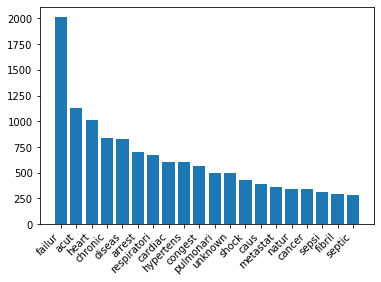

In [102]:
bow20 = bow_all.most_common(20)
bow20df=pd.DataFrame(bow20, columns=['Word', 'Count'])
plt.bar(bow20df['Word'], bow20df['Count'])
plt.xticks(rotation=45, ha='right')
plt.show()

**BY GC CATEGORY**

** GC category: 1-Septicemia **
[('acut kidney injuri', 46), ('acut respiratori failur', 42), ('failur septic shock', 40), ('hypox respiratori failur', 40), ('congest heart failur', 39), ('acut renal failur', 38), ('acut hypox respiratori', 26), ('chronic obstruct pulmonari', 26), ('obstruct pulmonari diseas', 25), ('hypoxem respiratori failur', 23), ('chronic kidney diseas', 23), ('urinari tract infect', 23), ('coronari arteri diseas', 22), ('end stage renal', 20), ('septic shock acut', 19), ('stage renal diseas', 18), ('acut hypoxem respiratori', 18), ('respiratori failur pneumonia', 18), ('pneumonia septic shock', 17), ('respiratori distress syndrom', 15), ('arrest septic shock', 15), ('septic shock unknown', 15), ('respiratori failur sepsi', 15), ('respiratori failur acut', 13), ('acut respiratori distress', 13), ('kidney injuri acut', 12), ('cardiac arrest septic', 12), ('organ failur septic', 12), ('sepsi septic shock', 12), ('methicillin resist staphylococc', 12)]


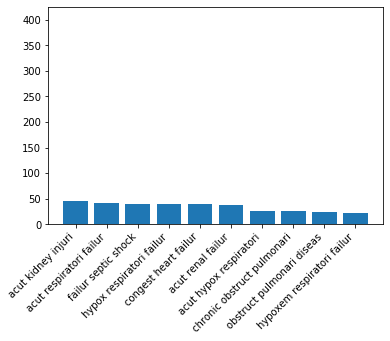

** GC category: 2-Heart failure **
[('congest heart failur', 400), ('heart failur acut', 88), ('heart failur chronic', 83), ('failur congest heart', 80), ('diastol heart failur', 71), ('diastol congest heart', 71), ('systol heart failur', 67), ('chronic obstruct pulmonari', 64), ('obstruct pulmonari diseas', 64), ('chronic kidney diseas', 55), ('acut respiratori failur', 53), ('heart failur congest', 51), ('failur acut chronic', 50), ('systol congest heart', 47), ('hypox respiratori failur', 46), ('chronic systol heart', 42), ('respiratori failur acut', 41), ('acut chronic systol', 35), ('failur chronic obstruct', 35), ('acut hypox respiratori', 33), ('chronic diastol congest', 31), ('arrest congest heart', 30), ('respiratori failur congest', 28), ('acut chronic diastol', 28), ('chronic diastol heart', 28), ('heart failur unspecifi', 25), ('failur cardiac arrest', 23), ('failur heart failur', 22), ('heart failur cardiac', 21), ('chronic heart failur', 20)]


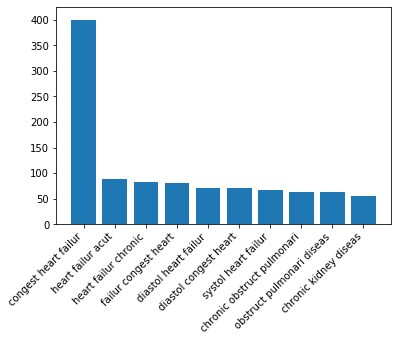

** GC category: 3-Ill-defined cancer **
[('cancer unknown primari', 70), ('metastat cancer unknown', 56), ('obstruct pulmonari diseas', 36), ('chronic obstruct pulmonari', 35), ('adenocarcinoma unknown primari', 35), ('unknown primari metastat', 31), ('coronari arteri diseas', 27), ('squamou cell carcinoma', 26), ('acut respiratori failur', 24), ('metastat adenocarcinoma unknown', 21), ('hypox respiratori failur', 20), ('carcinoma unknown primari', 20), ('congest heart failur', 17), ('cancer unknown origin', 17), ('acut renal failur', 15), ('malign unknown primari', 14), ('chronic kidney diseas', 13), ('respiratori failur metastat', 13), ('metastat cancer metastat', 12), ('unknown primari site', 12), ('metastat urotheli carcinoma', 11), ('protein calori malnutrit', 11), ('hypoxem respiratori failur', 11), ('unknown primari acut', 10), ('metastat squamou cell', 10), ('failur metastat cancer', 10), ('cancer metastat cancer', 9), ('secondari malign neoplasm', 9), ('acut hypox respiratori'

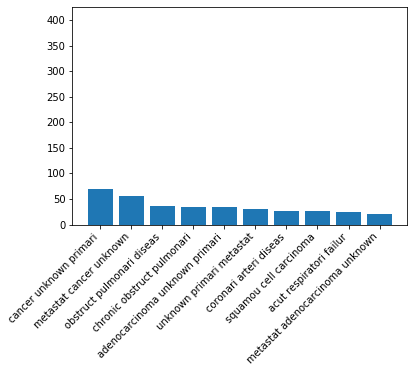

** GC category: 4-Volume depletion **
[('acut renal failur', 13), ('chronic kidney diseas', 11), ('congest heart failur', 11), ('acut respiratori failur', 8), ('acut kidney injuri', 8), ('coronari arteri diseas', 7), ('chronic obstruct pulmonari', 7), ('hypox respiratori failur', 6), ('renal failur dehydr', 6), ('obstruct pulmonari diseas', 6), ('acut hypox respiratori', 5), ('sever metabol acidosi', 5), ('atrial fibril rapid', 5), ('fibril rapid ventricular', 5), ('acut metabol encephalopathi', 5), ('cardiac arrest etiolog', 4), ('arrest etiolog unknown', 4), ('pulseless electr activ', 4), ('rapid ventricular respons', 4), ('heart failur acut', 4), ('chronic systol congest', 3), ('systol congest heart', 3), ('diseas diabet mellitu', 3), ('respiratori failur hypoxia', 3), ('failur congest heart', 3), ('respiratori failur acut', 3), ('failur acut renal', 3), ('dehydr inanit senesc', 3), ('kidney injuri chronic', 3), ('injuri chronic kidney', 3)]


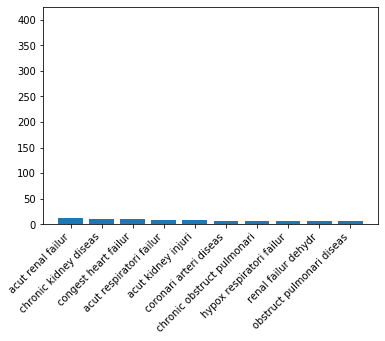

** GC category: 5-Ill-defined **
[('unspecifi natur caus', 86), ('unknown natur caus', 46), ('toxic use drug', 28), ('undetermin natur caus', 27), ('caus unspecifi natur', 25), ('natur caus unspecifi', 25), ('natur caus pend', 20), ('natur caus unknown', 20), ('natur caus otherwis', 19), ('caus otherwis specifi', 19), ('natur caus natur', 16), ('caus natur caus', 15), ('arrest unspecifi natur', 14), ('use drug acut', 14), ('caus cardiac arrest', 13), ('acut respiratori failur', 13), ('sudden unexplain death', 13), ('adult failur thrive', 12), ('natur caus sudden', 12), ('sudden unexplain infant', 12), ('unexplain infant death', 12), ('natur caus cardiac', 11), ('global geriatr declin', 11), ('intox toxic use', 11), ('anatom toxicolog caus', 10), ('toxicolog caus death', 10), ('hypertens cardiovascular diseas', 10), ('pend pend pend', 9), ('sudden cardiac death', 9), ('natur caus cardiopulmonari', 9)]


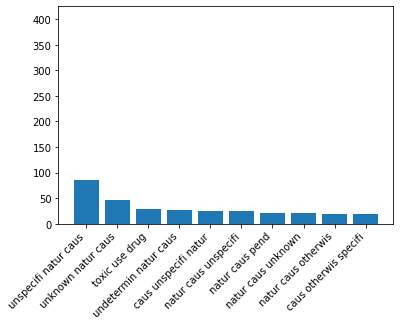

** GC category: 6-Ill-defined cardiovascular **
[('congest heart failur', 62), ('chronic obstruct pulmonari', 50), ('cardiac arrest hypertens', 49), ('obstruct pulmonari diseas', 48), ('natur caus hypertens', 37), ('probabl cardiac arrhythmia', 36), ('unspecifi natur caus', 33), ('chronic kidney diseas', 29), ('vascular dementia hypertens', 26), ('acut respiratori failur', 24), ('anox brain injuri', 21), ('acut renal failur', 20), ('peripher vascular diseas', 20), ('idiopath cardiopulmonari arrest', 19), ('hypertens atrial fibril', 17), ('atrial fibril hypertens', 17), ('hypox respiratori failur', 16), ('cardiopulmonari arrest hypertens', 16), ('hypertens cardiac arrest', 16), ('atherosclerot vascular diseas', 15), ('arrest probabl cardiac', 15), ('vascular diseas hypertens', 14), ('cardiopulmonari arrest probabl', 14), ('sudden cardiac death', 13), ('acut kidney injuri', 12), ('abdomin aortic aneurysm', 12), ('cardiac arrhythmia hypertens', 11), ('failur pulmonari embol', 11), ('acut 

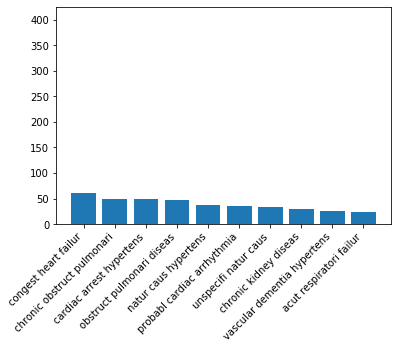

** GC category: 7-Ill-defined injury **
[]


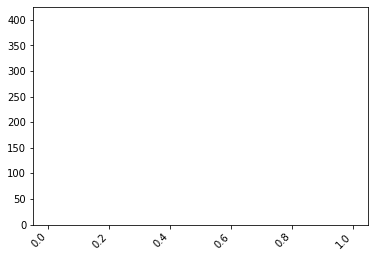

** GC category: 8-Undetermined intent **
[('blunt forc injuri', 20), ('multipl blunt forc', 11), ('forc injuri head', 9), ('acut drug intox', 6), ('intox toxic use', 5), ('toxic use drug', 5), ('fresh water drown', 4), ('salt water drown', 3), ('intox abus drug', 3), ('drug unknown intent', 3), ('uncertain circumst acut', 3), ('acut ethanol intox', 3), ('drown multipl blunt', 3), ('use drug acut', 3), ('drug intox heroin', 3), ('drown blunt forc', 2), ('drug acut combin', 2), ('ethanol intox toxic', 2), ('use drug unknown', 2), ('forc injuri descend', 2), ('impact injuri head', 2), ('head trunk extrem', 2), ('acut subdur hematoma', 2), ('inhal toxic combust', 2), ('toxic combust materi', 2), ('probabl fresh water', 2), ('appar drown multipl', 2), ('alcohol liver diseas', 2), ('intox heroin methamphetamin', 2), ('chronic ethanol abus', 2)]


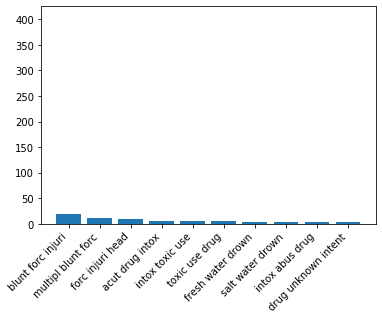

In [101]:
 for i in range(1, 9):
    cat_tokens = cod_txt.loc[cod_txt['gc_cat']== i, ['preprocd']]
    gcwordlist = cat_tokens['preprocd'].tolist()
    gcwordlist = [a for b in gcwordlist for a in b]
    gccod_trigrams = [' '.join(x) for x in getNgrams(gcwordlist, 3)]
    print('** GC category: ' + gc_label_dict.get(i) + ' **')
    bow_gctrigrams = Counter(gccod_trigrams)
    print(bow_gctrigrams.most_common(30))
    bowgc10 = bow_gctrigrams.most_common(10)
    bowgc10df = pd.DataFrame(bowgc10, columns=['Word', 'Count'])
    plt.bar(bowgc10df['Word'], bowgc10df['Count'])
    plt.xticks(rotation=45, ha='right')
    plt.ylim((0, 425))
    plt.show()

**NEXT STEPS**

- LDA by gc category to reapportion death to a more meaningful category

- train classifiers
    - naive bayes
    - multiple logistic regression